**Libraries**

In [ ]:
import os
from IPython.display import Audio
import librosa
import librosa.display as disp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from tqdm import tqdm, tqdm_pandas
import seaborn as sns
import itertools
from keras import regularizers

import keras
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D, BatchNormalization, Conv1D , MaxPooling1D

**Data Set**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "/content/drive/My Drive/Crema/"

def load_data(path):
    f_emotions = []
    f_pathes = []

    files = os.listdir(path)
    for file in files:
        step = file.split('.')[0]
        step = step.split('_')[2]
        f_emotions.append(step)
        f_pathes.append(path + file)
    return [f_emotions,f_pathes]

In [ ]:
emotion_df = []
Crema = "/content/drive/My Drive/Crema"
for wav in os.listdir(Crema):
    info = wav.partition(".wav")[0].split("_")
    if info[2] == 'SAD':
        emotion_df.append(("sad", Crema + "/" + wav))
    elif info[2] == 'ANG':
        emotion_df.append(("angry", Crema + "/" + wav))
    elif info[2] == 'DIS':
        emotion_df.append(("disgust", Crema + "/" + wav))
    elif info[2] == 'FEA':
        emotion_df.append(("fear", Crema + "/" + wav))
    elif info[2] == 'HAP':
        emotion_df.append(("happy", Crema + "/" + wav))
    elif info[2] == 'NEU':
        emotion_df.append(("neutral", Crema + "/" + wav))
    else:
        emotion_df.append(("unknown", Crema + "/" + wav))


Crema_df = pd.DataFrame.from_dict(emotion_df)
Crema_df.rename(columns={1 : "Path", 0 : "Emotion"}, inplace=True)

Crema_df.head()

,Emotion,Path
0,sad,/content/drive/My Drive/Crema/1079_IEO_SAD_LO.wav
1,angry,/content/drive/My Drive/Crema/1079_IEO_ANG_MD.wav
2,happy,/content/drive/My Drive/Crema/1079_IWW_HAP_XX.wav
3,sad,/content/drive/My Drive/Crema/1080_IOM_SAD_XX.wav
4,sad,/content/drive/My Drive/Crema/1080_MTI_SAD_XX.wav


In [ ]:
len(Crema_df)

7443

In [ ]:
%matplotlib inline

plt.style.use("ggplot")

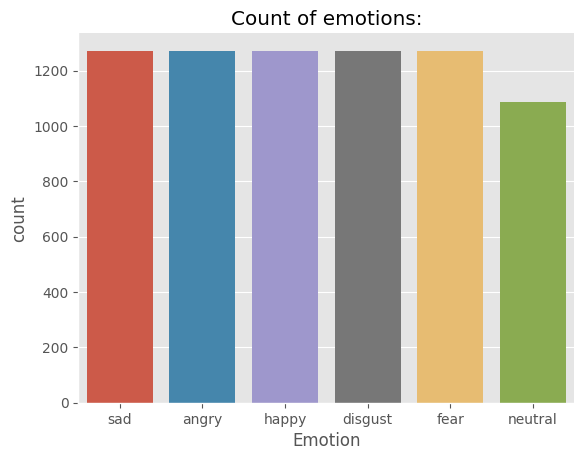

In [ ]:
plt.title("Count of emotions:")
sns.countplot(x=Crema_df["Emotion"])
sns.despine(top=True, right=True, left=False, bottom=False)

In [ ]:
def draw_wav(path):
    data,sr = librosa.load(path)
    plt.title('Audio wave :: ' + path)
    disp.waveshow(y=data,sr=sr)
    plt.show()

In [ ]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title(f'Waveplot for audio with {e} emotion', size=15)
    plt.plot(data)
    plt.show()

**Drawing Mel spectrogram from signal**

In [ ]:
def draw_melspectrogram(path):
    data,sr = librosa.load(path)
    x = librosa.feature.melspectrogram(y=data, sr=sr)
    #xdp = librosa.power_to_dp(x , ref=np.max)
    plt.title('melspectrogram for wave :: ' + path)
    disp.specshow(data=x,sr=sr , x_axis='s', y_axis='log')
    plt.show()
    return x

In [ ]:
def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

In [ ]:
#emotions,pathes = load_data(path)

In [ ]:
#emotions

In [ ]:
#pathes

In [ ]:
#print(emotions[0])
#draw_wav(pathes[0])
#melspectro = draw_melspectrogram(pathes[0])
#Audio(pathes[0])



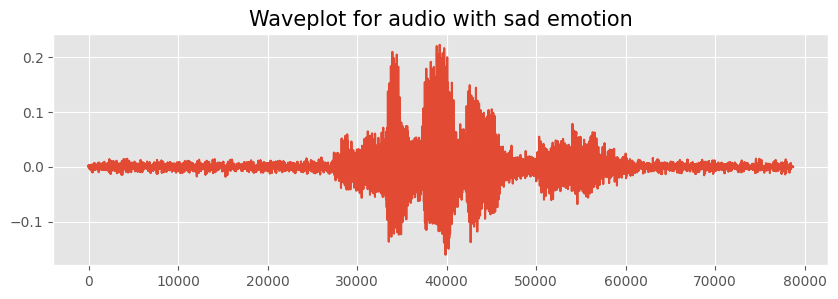

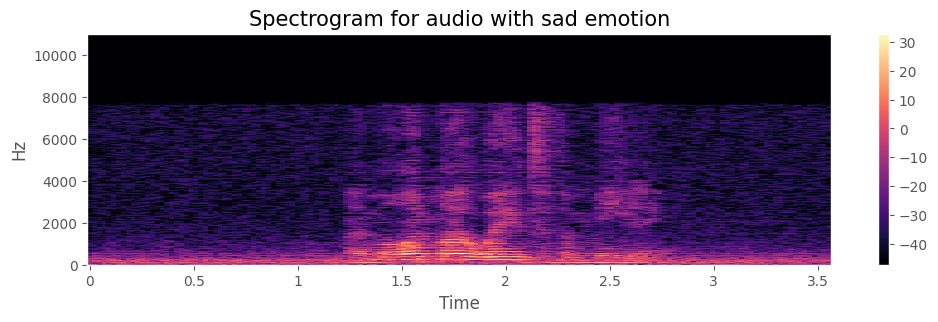

In [ ]:
emotion='sad'
path = np.array(Crema_df.Path[Crema_df.Emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

Zero Crossing Rate : The rate of sign-changes of the signal during the duration of a particular frame.
Energy : The sum of squares of the signal values, normalized by the respective frame length.
Entropy of Energy :The entropy of sub-frames’ normalized energies. It can be interpreted as a measure of abrupt changes.
Spectral Centroid : The center of gravity of the spectrum.
Spectral Spread : The second central moment of the spectrum.
Spectral Entropy : Entropy of the normalized spectral energies for a set of sub-frames.
Spectral Flux : The squared difference between the normalized magnitudes of the spectra of the two successive frames.
Spectral Rolloff : The frequency below which 90% of the magnitude distribution of the spectrum is concentrated.
MFCCs Mel Frequency Cepstral Coefficients form a cepstral representation where the frequency bands are not linear but distributed according to the mel-scale.

**augmentation**

In [ ]:
def pitch(data, sampling_rate, pitch_factor=0.5, random=True):
    if random:
        pitch_factor = np.random.random() * pitch_factor
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

In [ ]:
def noise(data, random=False, rate=0.035, threshold=0.075):
    """Add some noise to sound sample. Use random if you want to add random noise with some threshold.
    Or use rate Random=False and rate for always adding fixed noise."""
    if random:
        rate = np.random.random() * threshold
    noise_amp = rate*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

**Extracting RMS Energy feature**

In [ ]:
def rmse(data,frame_length=2048,hop_length=512):
    rmse=librosa.feature.rms(y=data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(rmse)

**Extracting Zero crossing rate feature**

In [ ]:
def zcr(data,frame_length=2048,hop_length=512):
    zcr=librosa.feature.zero_crossing_rate(y=data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr)

**Extraxting MFCC**

In [ ]:
def mfcc(data, sr, frame_length=2048, hop_length=512, flatten: bool = True):
    mfcc_feature = librosa.feature.mfcc(y=data, sr=sr)
    return np.squeeze(mfcc_feature.T) if not flatten else np.ravel(mfcc_feature.T)

**Extracting all features**

In [ ]:
def extract_features(data,sr,frame_length=2048,hop_length=512):
    result=np.array([])

    result=np.hstack((result,
                      zcr(data,frame_length,hop_length),
                      rmse(data,frame_length,hop_length),
                      mfcc(data, sr, frame_length, hop_length)
                     ))
    return result

In [ ]:
def get_features(path, duration=2.5, offset=0.6):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=duration, offset=offset)

     # without augmentation
    res1 = extract_features(data, sample_rate)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data, random=True)
    res2 = extract_features(noise_data, sample_rate)
    result = np.vstack((result, res2)) # stacking vertically

    # data with pitching
    pitched_data = pitch(data, sample_rate, random=True)
    res3 = extract_features(pitched_data, sample_rate)
    result = np.vstack((result, res3)) # stacking vertically

    # data with pitching and white_noise
    new_data = pitch(data, sample_rate, random=True)
    data_noise_pitch = noise(new_data, random=True)
    res3 = extract_features(data_noise_pitch, sample_rate)
    result = np.vstack((result, res3)) # stacking vertically

    return result

**Data Preparation**

In [ ]:
#label encoding for changing label to categorical features
label_encoder = preprocessing.LabelEncoder()
emotions_y= label_encoder.fit_transform(Crema_df.Emotion)
emotions_y = keras.utils.to_categorical(emotions_y,num_classes=6)

In [ ]:
X_train_1d, X_test_1d, y_train_1d, y_test_1d = train_test_split(Crema_df.Path, emotions_y, train_size = 0.7, stratify = emotions_y , random_state=42)

In [ ]:
X_train_1d, X_valid_1d, y_train_1d, y_valid_1d = train_test_split(X_train_1d, y_train_1d, train_size = 0.95, stratify = y_train_1d , random_state=42)

In [ ]:
#X = extracted_df.drop(labels="labels", axis=1)
#Y = extracted_df["labels"]
X_valid_1d.shape[0]

261

In [ ]:
X, Y = [], []
for path, emotion, ind in zip(X_train_1d, y_train_1d, range(X_train_1d.shape[0])):
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    features = extract_features(data, sample_rate)
    #features = get_features(path)
    if ind % 100 == 0:
        print(f"{ind} samples has been processed...")
    #for ele in features:
    X.append(features)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
    Y.append(emotion)

0 samples has been processed...
100 samples has been processed...
200 samples has been processed...
300 samples has been processed...
400 samples has been processed...
500 samples has been processed...
600 samples has been processed...
700 samples has been processed...
800 samples has been processed...
900 samples has been processed...
1000 samples has been processed...
1100 samples has been processed...
1200 samples has been processed...
1300 samples has been processed...
1400 samples has been processed...
1500 samples has been processed...
1600 samples has been processed...
1700 samples has been processed...
1800 samples has been processed...
1900 samples has been processed...
2000 samples has been processed...
2100 samples has been processed...
2200 samples has been processed...
2300 samples has been processed...
2400 samples has been processed...
2500 samples has been processed...
2600 samples has been processed...
2700 samples has been processed...
2800 samples has been processed.

In [ ]:
X1, Y1 = [], []
for path, emotion, ind in zip(X_test_1d, y_test_1d, range(X_test_1d.shape[0])):
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    features = extract_features(data, sample_rate)
    #features = get_features(path)
    if ind % 100 == 0:
        print(f"{ind} samples has been processed...")
    #for ele in features:
    X1.append(features)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
    Y1.append(emotion)

0 samples has been processed...
100 samples has been processed...
200 samples has been processed...
300 samples has been processed...
400 samples has been processed...
500 samples has been processed...
600 samples has been processed...
700 samples has been processed...
800 samples has been processed...
900 samples has been processed...
1000 samples has been processed...
1100 samples has been processed...
1200 samples has been processed...
1300 samples has been processed...
1400 samples has been processed...
1500 samples has been processed...
1600 samples has been processed...
1700 samples has been processed...
1800 samples has been processed...
1900 samples has been processed...
2000 samples has been processed...
2100 samples has been processed...
2200 samples has been processed...


In [ ]:
X2, Y2 = [], []
for path, emotion, ind in zip(X_valid_1d, y_valid_1d, range(X_valid_1d.shape[0])):
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    features = extract_features(data, sample_rate)
    features = np.array(features)
    #features = get_features(path)
    if ind % 100 == 0:
        print(f"{ind} samples has been processed...")
    #for ele in features:
    X2.append(features)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
    Y2.append(emotion)

0 samples has been processed...
100 samples has been processed...
200 samples has been processed...


In [ ]:
np.shape(features)

(1760,)

In [ ]:
np.shape(X1)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:2007: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


(2233,)

In [ ]:
X=pd.DataFrame(X)
X1=pd.DataFrame(X1)
X2=pd.DataFrame(X2)

In [ ]:
X=X.fillna(0)


In [ ]:
X1=X1.fillna(0)

In [ ]:
X2=X2.fillna(0)

In [ ]:
extracted_train = X
extracted_train_y = Y

In [ ]:
extracted_test = X1
extracted_test_y= Y1

In [ ]:
extracted_valid = X2
extracted_valid_y = Y2

In [ ]:
np.shape(extracted_valid)

(261, 2376)

In [ ]:
scaler = StandardScaler()
X_train_1d = scaler.fit_transform(extracted_train)
X_test_1d = scaler.transform(extracted_test)
X_valid_1d = scaler.transform(extracted_valid)
X_train_1d.shape, X_test_1d.shape, X_valid_1d.shape, y_train_1d.shape, y_test_1d.shape, y_valid_1d.shape

((4949, 2376), (2233, 2376), (261, 2376), (4949, 6), (2233, 6), (261, 6))

In [ ]:
np.shape(X_test_1d[100])

(2376,)

**conv1D model**

In [ ]:
train_1d = tf.convert_to_tensor(X_train_1d)
label_1d = tf.convert_to_tensor(y_train_1d)

In [ ]:
test_1d = tf.convert_to_tensor(X_test_1d)
label_test_1d = tf.convert_to_tensor(y_test_1d)

In [ ]:
X_valid_1d = tf.convert_to_tensor(X_valid_1d)
y_valid_1d = tf.convert_to_tensor(y_valid_1d)

In [ ]:
np.shape(train_1d)

TensorShape([4949, 2376])

In [ ]:
np.shape(label_1d)

TensorShape([4949, 6])

In [ ]:
model = Sequential()
model.add(Conv1D(64, kernel_size=5, strides=1,
                        padding="same", activation="relu",
                        input_shape=(X_train_1d.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides=2, padding="valid"))
model.add(BatchNormalization())

model.add(Conv1D(128, kernel_size=5, strides=1,
                        padding="same", activation="relu"))
model.add(MaxPooling1D(pool_size=5, strides=2, padding="same"))
#model.add(BatchNormalization())

model.add(Conv1D(256, kernel_size=5, strides=1,
                        padding="same", activation="relu"))
model.add(MaxPooling1D(pool_size=5, strides=2, padding="same"))


model.add(Dropout(0.7))

model.add(Flatten())
#model.add(Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.01), activity_regularizer=regularizers.l1(0.01)))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
#model.add(BatchNormalization())
model.add(Dense(6, activation="softmax"))

model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 2376, 64)          384       
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 1186, 64)         0         
 1D)                                                             
                                                                 
 batch_normalization_1 (Batc  (None, 1186, 64)         256       
 hNormalization)                                                 
                                                                 
 conv1d_7 (Conv1D)           (None, 1186, 128)         41088     
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 593, 128)         0         
 1D)                                                             
                                                      

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stop=EarlyStopping(monitor='val_accuracy',mode='auto',patience=5,restore_best_weights=True)
lr_reduction=ReduceLROnPlateau(monitor='val_accuracy',patience=3,verbose=1,factor=0.5,min_lr=0.0001)

In [ ]:
model.fit(train_1d,label_1d,epochs = 100,validation_data=(X_valid_1d,y_valid_1d), batch_size=16, callbacks = [lr_reduction])

Epoch 1/100
310/310 [==============================] - 228s 727ms/step - loss: 1.8582 - accuracy: 0.2085 - val_loss: 1.7714 - val_accuracy: 0.2375 - lr: 0.0010
Epoch 2/100
310/310 [==============================] - 219s 706ms/step - loss: 1.7893 - accuracy: 0.2170 - val_loss: 1.7793 - val_accuracy: 0.2107 - lr: 0.0010
Epoch 3/100
310/310 [==============================] - 222s 716ms/step - loss: 1.7688 - accuracy: 0.2219 - val_loss: 1.7385 - val_accuracy: 0.2567 - lr: 0.0010
Epoch 4/100
310/310 [==============================] - 215s 693ms/step - loss: 1.7590 - accuracy: 0.2370 - val_loss: 1.7497 - val_accuracy: 0.2682 - lr: 0.0010
Epoch 5/100
310/310 [==============================] - 226s 727ms/step - loss: 1.7496 - accuracy: 0.2417 - val_loss: 1.6725 - val_accuracy: 0.3218 - lr: 0.0010
Epoch 6/100
310/310 [==============================] - 224s 722ms/step - loss: 1.7172 - accuracy: 0.2584 - val_loss: 1.7039 - val_accuracy: 0.2682 - lr: 0.0010
Epoch 7/100
310/310 [===================

In [ ]:
model.evaluate(test_1d,label_test_1d)

NameError: ignored

In [ ]:
y_pred_1d = model.predict(test_1d)
y_pred_1d = np.argmax(y_pred_1d, axis=1)
y_pred_1d

In [ ]:
y_check_1d = np.argmax(label_test_1d, axis=1)
y_check_1d

In [ ]:
from sklearn.metrics import confusion_matrix

cm_1d = confusion_matrix(y_true=y_check_1d, y_pred=y_pred_1d)

In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,  #can change to true
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
cm_plot_labels_1d = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
plot_confusion_matrix(cm=cm_1d, classes=cm_plot_labels_1d, title='Confusion Matrix')

**Extracting Mel Spectrogram Feature**

In [ ]:
np.shape(Crema_df)[0]

7443

In [ ]:
Crema_df["Path"][3]

'/content/drive/My Drive/Crema/1080_IOM_SAD_XX.wav'

In [ ]:
melspect = []
for i in range (np.shape(Crema_df)[0]):
  data,sr = librosa.load(Crema_df["Path"][i])
  frame_length=2048
  hop_length=512
  flatten: bool = True
  x = librosa.feature.melspectrogram(y=data, sr=sr)
  if x.shape[1] < 216:
        tobeadded = 216 - x.shape[1] #To know how many zero column we will add
        zeros = np.zeros((128, tobeadded))
        x = np.hstack((x, zeros)) # adding the columns
  melspect.append(x)

In [ ]:
len(data)

74309

In [ ]:
np.shape(melspect)

(7443, 128, 216)

In [ ]:
#melspect

In [ ]:
#Normalizing the data
for i in range(0, len(melspect)):
    scaler=StandardScaler()
    melspect[i] = scaler.fit_transform(melspect[i])

In [ ]:
#label encoding for changing label to categorical features
label_encoder = preprocessing.LabelEncoder()
emotions= label_encoder.fit_transform(Crema_df["Emotion"])
df_y = keras.utils.to_categorical(emotions,num_classes=6)

In [ ]:
np.shape(df_y)

(7443, 6)

In [ ]:
df_y

array([[0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
df_y = np.array(df_y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(melspect, df_y, train_size = 0.7, stratify = df_y , random_state=42)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size = 0.95, stratify = y_train , random_state=42)

**Data Augmentation**

We have some ways for data augmentation in sound data:

Noise injection
Stretching
Shifting
Pitching

In [ ]:
def noisy_signal(signal,snr_low=15,snr_high=30,nb_augmented=2):

  signal_len = len(signal)
  noise = np.random.normal(size = (nb_augmented,signal_len))

  #compute signal & noise power
  s_power = np.sum((signal / (2.0 ** 15)) ** 2 ) / signal_len
  n_power = np.sum((noise / (2.0 ** 15)) ** 2 , axis = 1 ) / signal_len
  snr = np.random.randint(snr_low , snr_high)

  #compute k coeff for each signal
  k = np.sqrt((s_power / n_power) * 10) ** (- snr / 10)
  k = np.ones((nb_augmented, signal_len )) * k

  return signal + k.T * noise

**Convolution Neural Network Model for 2D Melspectrogram**

In [ ]:
train = tf.convert_to_tensor(X_train)
label = tf.convert_to_tensor(y_train)

In [ ]:
test = tf.convert_to_tensor(X_test)
label_test = tf.convert_to_tensor(y_test)

In [ ]:
X_valid = tf.convert_to_tensor(X_valid)
y_valid = tf.convert_to_tensor(y_valid)

In [ ]:
np.shape(train)

In [ ]:
np.shape(label)

model = Sequential()
model.add(Conv2D(32,3,data_format='channels_last',activation='relu',input_shape=(128,216,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(100))
model.add(Dropout(0.5))
model.add(Dense(6))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer = 'adadelta', metrics = ['accuracy'])

In [ ]:
model_spect = Sequential()
model_spect.add(Conv2D(16,kernel_size =(5, 5), strides =(1, 1),
                 activation ='relu',padding="same", input_shape=(128, 216, 1)))
model_spect.add(MaxPooling2D(pool_size =(2, 2), strides =(2, 2),padding = "valid"))
model_spect.add(BatchNormalization())

model_spect.add(Conv2D(32, (5, 5), activation ='relu',padding="same"))
model_spect.add(MaxPooling2D(pool_size =(2, 2),padding = "valid"))
model_spect.add(BatchNormalization())

model_spect.add(Conv2D(64, (3, 3), activation ='relu',padding="same"))
model_spect.add(MaxPooling2D(pool_size =(2, 2),padding = "valid"))
model_spect.add(BatchNormalization())

model_spect.add(Conv2D(128, (3, 3), activation ='relu',padding="same"))
model_spect.add(MaxPooling2D(pool_size =(2, 2),padding = "valid"))

model_spect.add(Dropout(0.8))

model_spect.add(Flatten())
model_spect.add(Dense(500, activation ='relu',kernel_regularizer=regularizers.l2(0.01)))
model_spect.add(Dense(128, activation ='relu'))
model_spect.add(Dense(64, activation ='relu'))
model_spect.add(Dense(32, activation ='relu'))
model_spect.add(Dense(16, activation ='relu'))
model_spect.add(BatchNormalization())
model_spect.add(Dense(6, activation ='softmax'))

model_spect.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
model_spect.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 128, 216, 16)      416       
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 64, 108, 16)      0         
 g2D)                                                            
                                                                 
 batch_normalization_20 (Bat  (None, 64, 108, 16)      64        
 chNormalization)                                                
                                                                 
 conv2d_23 (Conv2D)          (None, 64, 108, 32)       12832     
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 32, 54, 32)       0         
 g2D)                                                            
                                                      

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stop=EarlyStopping(monitor='val_accuracy',mode='auto',patience=5,restore_best_weights=True)
lr_reduction=ReduceLROnPlateau(monitor='val_accuracy',patience=3,verbose=1,factor=0.5,min_lr=0.00001)

In [ ]:
model_spect.fit(train,label,epochs = 60,validation_data=(X_valid,y_valid), batch_size=10, callbacks = [lr_reduction])

Epoch 1/60
495/495 [==============================] - 13s 15ms/step - loss: 1.6851 - accuracy: 0.2974 - val_loss: 1.5481 - val_accuracy: 0.3487 - lr: 0.0010
Epoch 2/60
495/495 [==============================] - 7s 14ms/step - loss: 1.5542 - accuracy: 0.3488 - val_loss: 1.6982 - val_accuracy: 0.2989 - lr: 0.0010
Epoch 3/60
495/495 [==============================] - 7s 14ms/step - loss: 1.4944 - accuracy: 0.3918 - val_loss: 1.4294 - val_accuracy: 0.3870 - lr: 0.0010
Epoch 4/60
495/495 [==============================] - 7s 14ms/step - loss: 1.4605 - accuracy: 0.4106 - val_loss: 1.4535 - val_accuracy: 0.4253 - lr: 0.0010
Epoch 5/60
495/495 [==============================] - 7s 14ms/step - loss: 1.4450 - accuracy: 0.4160 - val_loss: 1.4829 - val_accuracy: 0.4061 - lr: 0.0010
Epoch 6/60
495/495 [==============================] - 7s 14ms/step - loss: 1.3834 - accuracy: 0.4480 - val_loss: 1.3923 - val_accuracy: 0.4291 - lr: 0.0010
Epoch 7/60
495/495 [==============================] - 7s 14ms/s

In [ ]:
model_spect.evaluate(X_valid,y_valid)

70/70 [==============================] - 1s 15ms/step - loss: 1.2624 - accuracy: 0.5387


[1.2623894214630127, 0.5387371182441711]

In [ ]:
model_spect.evaluate(test,label_test)

70/70 [==============================] - 1s 13ms/step - loss: 1.3664 - accuracy: 0.5343


[1.3664135932922363, 0.5342588424682617]

In [ ]:
y_pred = model_spect.predict(test)
y_pred

70/70 [==============================] - 1s 9ms/step


array([[0.02192777, 0.03301914, 0.3914328 , 0.19144718, 0.08892074,
        0.27325237],
       [0.13536108, 0.2770534 , 0.10666919, 0.33323577, 0.0920431 ,
        0.0556375 ],
       [0.51672643, 0.04422712, 0.00616111, 0.4281156 , 0.00305318,
        0.00171653],
       ...,
       [0.22950315, 0.03784591, 0.15072945, 0.54691344, 0.01488346,
        0.0201246 ],
       [0.19219339, 0.04415977, 0.4807249 , 0.2115852 , 0.01909556,
        0.05224118],
       [0.00311209, 0.16684991, 0.01414717, 0.01145966, 0.03724298,
        0.7671882 ]], dtype=float32)

In [ ]:
y_pred = np.argmax(y_pred, axis=1)
y_pred

array([2, 3, 0, ..., 3, 2, 5])

In [ ]:
y_check = np.argmax(label_test, axis=1)
y_check

array([2, 3, 3, ..., 3, 3, 4])

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true=y_check, y_pred=y_pred)

In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,  #can change to true
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Confusion matrix, without normalization
[[269  40   6  49  14   4]
 [ 41 169  36  25  45  65]
 [ 17  29 187  52  15  82]
 [ 47  27  73 198  24  12]
 [  9  27  20  21 209  40]
 [  1  37  65   9  54 215]]


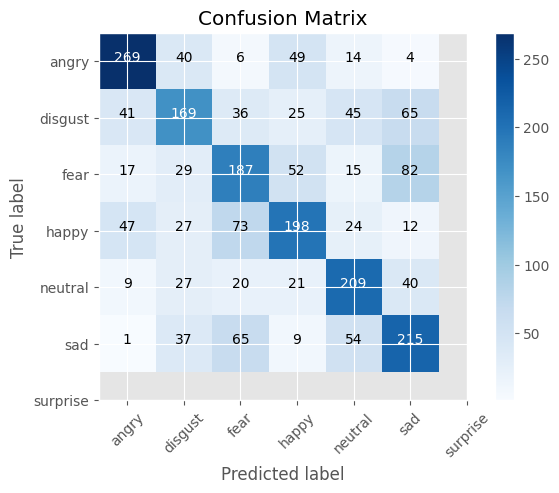

In [ ]:
cm_plot_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')